# Tensorflow implementation 02: CNN

by [Sho Nakagome](https://github.com/shonaka)

This jupyter notebook is intended to implement a simple CNN (Convolutional Neural Network) model on classification problems. In this notebook, we are using fashion MNIST: https://github.com/zalandoresearch/fashion-mnist

Make sure you follow the instruction in the above URL if you cannot read data.

This work is inspired by: https://github.com/Hvass-Labs/TensorFlow-Tutorials

This notebook is more for a tutorial and the practical code with tensorboard implementation and other functions will be implemented in python codes in the same github repository.

## Imports

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# Just to make plotting images larger on the jupyter notebook
plt.rcParams['figure.figsize'] = (12, 8)

/home/snakagom/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Programming environment: Python 3.6 (Anaconda)

In [2]:
tf.__version__

'1.5.0'

## Define global variables

Now let's define some global variables to be used in the code.

In [3]:
# Image related
IMG_HEIGHT = 28
IMG_WIDTH = 28
# total number of pixels in an image
IMG_TOT = IMG_HEIGHT * IMG_WIDTH
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH)
# number of classes
NUM_CLASSES = 10
# labels corresponding to the numbers
LABELS = ['t_shirt_top',  # 0
          'trouser',      # 1
          'pullover',     # 2
          'dress',        # 3
          'coat',         # 4
          'sandal',       # 5
          'shirt',        # 6
          'sneaker',      # 7
          'bag',          # 8
          'ankle_boots']  # 9

# Optimization related
LEARNING_RATE = 1e-3
BATCH_SIZE = 64  # Better to have a batch size 2^n
NUM_EPOCHS = BATCH_SIZE * 10
# CNN related
# Number of channels
NUM_CHANNELS = 1  # Since we are using gray-scale
# 1st CNN layer info
FILTER_SIZE1 = 5
NUM_FILTERS1 = 50
# 2nd CNN layer info
FILTER_SIZE2 = 20
NUM_FILTERS2 = 30
# Last fully-connected layer info
FC_SIZE = 128

## Import data and checking the dataset

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/fashion', 
                                 source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/',
                                 one_hot=True)

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


Now we imported the data, let's first check the dimensions of the dataset.

In [5]:
print("Checking number of images in the dataset:")
print("\tTraining set:\t\t{0}".format(len(data.train.labels)))
print("\tValidation set:\t\t{0}".format(len(data.validation.labels)))
print("\tTest set:\t\t{0}".format(len(data.test.labels)))

Checking number of images in the dataset:
	Training set:		55000
	Validation set:		5000
	Test set:		10000


Let's also check the example labels. Right now, it's loaded as one-hot vector. This means that the true class is indicated as 1 in the vector, the rest is 0. Each row represents different samples.

In [6]:
print("Example training labels:")
print(data.train.labels[0:5, :])

Example training labels:
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


Other than one-hot vector, we also need classes indicated by the integers for calculating the accuracies and plotting purposes. Using numpy to find the index and assiging a class in integers.

In [7]:
# Define another class labels where the true class is indicated by the integer values
data.train.cls = np.array([label.argmax() for label in data.train.labels])
data.validation.cls = np.array([label.argmax() for label in data.validation.labels])
data.test.cls = np.array([label.argmax() for label in data.test.labels])

# Showing an example
print(data.test.cls[0:5])

[9 2 1 1 6]


Now let's define a helper function to visualize some images and labels. This will be used later to visualize some misclassified images too.

In [8]:
def plt_image_labels(images, num_row, num_col, class_true, class_pred=None):
    """
    Plot images with true labels. If specified, predicted class too.
    
    :param images: the image data itself, containing pixel data.
    :param num_row: how many number of rows you want to plot.
    :param num_col: how many number of columns you want to plot.
    :param class_true: the true class labels for the images you give as the first input.
    :param class_pred: the predicted class labels. If not specified, it does not plot the labels.
    """
    # Check if the specified num_row and num_col matches the total number of images
    assert len(images) == len(class_true) == num_row * num_col
    
    # Create a subplot of num_row x num_col
    fig, axes = plt.subplots(num_row, num_col)
    fig.subplots_adjust(hspace=0.1*num_row, wspace=0.1*num_col)
    
    # for each image, plot the image and the true label. If there's predicted, plot that too.
    for i, ax in enumerate(axes.flat):
        # Plot the image
        ax.imshow(images[i].reshape(IMG_SHAPE), cmap='binary')
        
        # Show labels
        if class_pred is None:
            xlabel = "True: {0}".format(LABELS[class_true[i]])
        else:
            xlabel = "True: {0},  Pred: {1}".format(LABELS[class_true[i]],
                                                   LABELS[class_pred[i]])
            
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])

Plotting few images and labels for checking.

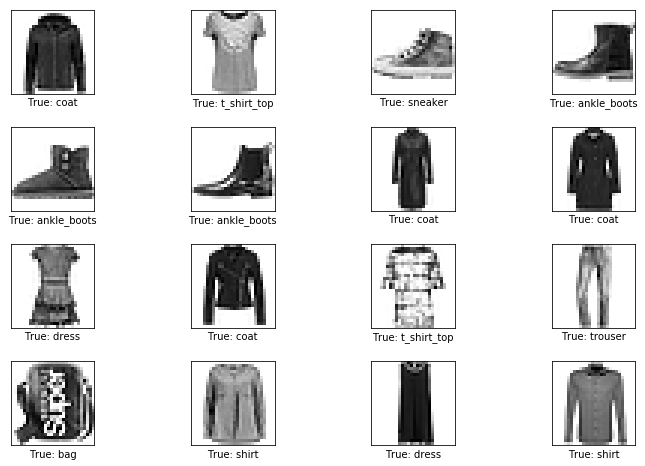

In [9]:
images = data.train.images[0:16]
class_true = data.train.cls[0:16]

# Plot using the function you made above
plt_image_labels(images=images, num_row=4, num_col=4, class_true=class_true)

## Define tensorflow graph

Tensorflow requires you to construct and computation graph first with placeholders and variables (to be optimized) before actually calculating the predictions. If you want to know more about the computational graph and classes used here, please refer to the official document [here](https://www.tensorflow.org/get_started/get_started).


### Defining CNN functions

Convolutional Neural Network (CNN) uses filters (or kernels) to convolve with an input to transform the input volume (usually height x width x channels (e.g. RGB)) into an output volume of different size.

Here, we are defining a very simple CNN with 2 layers of covolution.

First, we are defining a helper function to define weights and biases. We will use Xavier initialization. Weight initialization is importatn in order to avoid vanishing or exploding gradients and to know more about the details, please refer to Andrew Ng's deeplearning.ai course 2, week 1 for more information.

In [10]:
def new_weights(name, shape):
    """
    Defining a new weights based on the name and the shape.
    Initialized with Xavier initializer
    
    :param name: name of the new defined weights
    :param shape: shape of the new defined filter
    """
    
    W = tf.get_variable(name=name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())
    
    return W

Next, we are defining a helper function to define a simple CNN structure only using different convolutional layers and fully-connected layers. We will be using other layers such as maxpool in a more larger input images later.

In [11]:
def simpleCNN(X):
    """
    Plot images with true labels. If specified, predicted class too.
    
    :param images: the image data itself, containing pixel data.
    :param num_row: how many number of rows you want to plot.
    :param num_col: how many number of columns you want to plot.
    :param class_true: the true class labels for the images you give as the first input.
    :param class_pred: the predicted class labels. If not specified, it does not plot the labels.
    """
    
    # Get new weights
    W1 = new_weights("W1", [FILTER_SIZE1, FILTER_SIZE1, NUM_CHANNELS, NUM_FILTERS1])
    W2 = new_weights("W2", [FILTER_SIZE2, FILTER_SIZE2, NUM_FILTERS1, NUM_FILTERS2])

    # CONV2D: Define your first CNN layer
    Z1 = tf.nn.conv2d(input=X,
                      filter=W1,
                      strides=[1, 1, 1, 1],
                      padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # CONV2D: 2nd CNN layer
    Z2 = tf.nn.conv2d(input=A1,
                      filter=W2,
                      strides=[1, 1, 1, 1],
                      padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # FLATTEN (from a convolutional volume, we are flatting it out to a single vector like layer)
    P = tf.contrib.layers.flatten(A2)
    # FULLY-CONNECTED layer
    # We have 10 neurons in the output layer because we have 10 classes to classify. 
    final_output = tf.contrib.layers.fully_connected(P, 10, activation_fn=None)

    return final_output

In [12]:
# Define place holders. These are where your input and output goes when actually computing.
X = tf.placeholder(tf.float32, shape=[None, IMG_TOT], name="X")
X_image = tf.reshape(X, [-1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS])
Y = tf.placeholder(tf.float32, [None, NUM_CLASSES], name="Y")
Y_true_class = tf.argmax(Y, axis=1, name="Y_true_class")
# Make sure you check the dimensions
# Dimension of X should be [batch, height, width, number of channels]
print(X)
print(X_image)
print(Y)
print(Y_true_class)

Tensor("X:0", shape=(?, 784), dtype=float32)
Tensor("Reshape:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("Y:0", shape=(?, 10), dtype=float32)
Tensor("Y_true_class:0", shape=(?,), dtype=int64)


Now we define a linear model.

In [13]:
# Defining a simple CNN model using the function defined before
model = simpleCNN(X_image)

# Use softmax layer to normalize the output and then get the highest number to determine the class
Y_pred = tf.nn.softmax(model)
Y_pred_class = tf.argmax(Y_pred, axis=1)

We also need to define a loss function. This time, we are using cross entropy which is one of the most commonly used loss function with CNN.

Also note that we are passing "model" into the logits because the softmax is internally calculated in the cross-entropy built-in function.

In [14]:
# Define loss function. Least squared error
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=Y),
                      name="cross_entropy")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



And finally, we are going to define optimization method. This time, we are using Adam optimizer which is also another most commonly used optimizer with CNN.

In [15]:
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(cost, name="minimizer")

We also need to define performance measures

In [16]:
correct_prediction = tf.equal(Y_pred_class, Y_true_class)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Running tensorflow session

From here, we are going to run the tensorflow graph defined above. Usually, you put the above codes into functions and then from here, you execute the session. You could write the below codes into the main function.

At first, we are going to define a global variable initializer. Then, we define a tensorflow session and run everything inside. Usually, you log everything into the tensorboard and visualize the loss and the accuracy but those implementations will be explained in the folder named TF01_linear_model in the same github repository.

In [17]:
# Make sure that you never call this before creating a model since it requires that you have defined a graph already.
init = tf.global_variables_initializer()

# Running a tensorflow session
with tf.Session() as sess:
    print("Initializing all the variables.")
    sess.run(init)
    
    # Initialize some variables for logging results.
    # This will not be needed in python code where you use tensorboard.
    loss_record = [];
    train_record = [];
    
    print("Start training.")
    for i in range(NUM_EPOCHS):
        # Get a batch of training samples. Every time this is called within a loop,
        # it gets the next batch.
        x_batch, y_batch = data.train.next_batch(BATCH_SIZE)
        
        # Create a dict with batched samples. This will go into the optimizer to train the model.
        feed_dict_train = {X: x_batch, Y: y_batch}
        
        # Run the optimization and calculate the loss
        result_l, _ = sess.run([cost, optimizer], feed_dict=feed_dict_train)
        mean_loss = np.mean(result_l)
        loss_record.append(mean_loss)
        
        # Also calculate the training accuracy
        y_batch_class = np.array([label.argmax() for label in y_batch])
        feed_dict_train_no_one_hot = {X: x_batch, Y_true_class: y_batch_class}
        acc_train = sess.run(accuracy, feed_dict=feed_dict_train_no_one_hot)
        train_record.append(acc_train)
        
        # Print the loss and the training accuracy every 10 iteration
        if i % BATCH_SIZE == 0:
            print("Loss function: %.4f" % mean_loss)
            print("Training accuracy: {0:>6.1%}".format(acc_train))
            
    print("Training finished.")
    
    print("\nStart testing.")
    # We are going to feed all the test samples
    feed_dict_test = {X: data.test.images,
                  Y: data.test.labels,
                  Y_true_class: data.test.cls}

    # Calculate the accuracy
    acc, true_label, pred_label = sess.run([accuracy, correct_prediction, Y_pred_class],
                                           feed_dict=feed_dict_test)

# Print the accuracy
print("Test accuracy: {0:.1%}".format(acc))

Initializing all the variables.
Start training.
Loss function: 2.3102
Training accuracy:  20.3%
Loss function: 0.6315
Training accuracy:  78.1%
Loss function: 0.5663
Training accuracy:  81.2%
Loss function: 0.5805
Training accuracy:  79.7%
Loss function: 0.6345
Training accuracy:  81.2%
Loss function: 0.3298
Training accuracy:  89.1%
Loss function: 0.3560
Training accuracy:  85.9%
Loss function: 0.5106
Training accuracy:  82.8%
Loss function: 0.4329
Training accuracy:  85.9%
Loss function: 0.2658
Training accuracy:  92.2%
Training finished.

Start testing.
Test accuracy: 86.7%


## Analyzing the results

From here, we are going to step in a bit to analyze the results. First, let's define some helper functions for plotting loss and training accuracy as well as examples of misclassified images.

In [18]:
# Defining a helper function to plot loss and accuracy.
# This part will be replaced with tensorboard in the python code tutorial in the same github repo.
def plot_loss_acc(loss_values, acc_values, loss_label, acc_label):
    """
    
    Plot loss and accuracy.
    
    :param loss_values: a vector of loss values for plotting.
    :param acc_values: a vector of accuracy values for plotting.
    :param loss_label: a string for loss value plot. e.g. 'Training loss'.
    :param acc_label: a string for accuracy value plot. e.g. 'Training accuracy'.
    
    """
    # Create subplots for loss and accuracy. Sharing x axis as num epochs
    fig, axes = plt.subplots(2, sharex=True)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # For loss
    axes[0].plot(loss_values)
    axes[0].set_ylabel(loss_label)
    
    # For accuracy
    axes[1].plot(acc_values)
    axes[1].set_ylabel(acc_label)

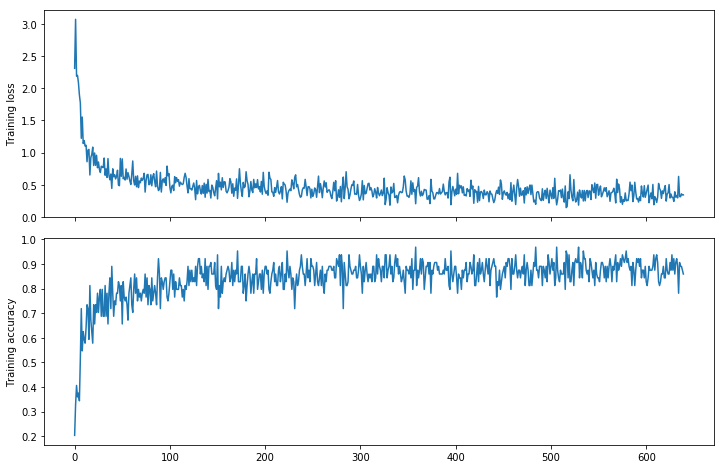

In [19]:
# Plotting training loss and accuracy to see how well the model was trained
plot_loss_acc(loss_record, train_record, 'Training loss', 'Training accuracy')

We can see that the loss has dropped significantly in the first 30 epochs and stabilizes. The training accuracy is noisy but constantly increasing. Note that we haven't taken any steps to avoid over-fitting problem just yet, but it's generally a first step to make the model over-fit first and then move on to the next step. Otherwise, you might be having some other problems that won't even let you over-fit.

### Plotting misclassified images
We visualized loss and accuracy in the above plots. Now let's see what kinds of images were misclassified tso that we could see and understand what kinds of images are difficult to classify.

In [20]:
# Defining a helper function to plot misclassified images
def plot_example_errors():
    """
    
    Plot misclassified images with true and predicted labels.
    
    """
    # Inverse the label
    incorrect = (true_label == False)
    
    # Get the misclassified images
    miss_class_images = data.test.images[incorrect]
    
    # Extract predicted labels for the misclassified images
    class_pred = pred_label[incorrect]
    
    # Extract true labels like the same
    class_true = data.test.cls[incorrect]
    
    # Use the helper function you made before to plot them
    plt_image_labels(images=miss_class_images[0:16],
                     num_row=4,
                     num_col=4,
                     class_true=class_true[0:16],
                     class_pred=class_pred[0:16])

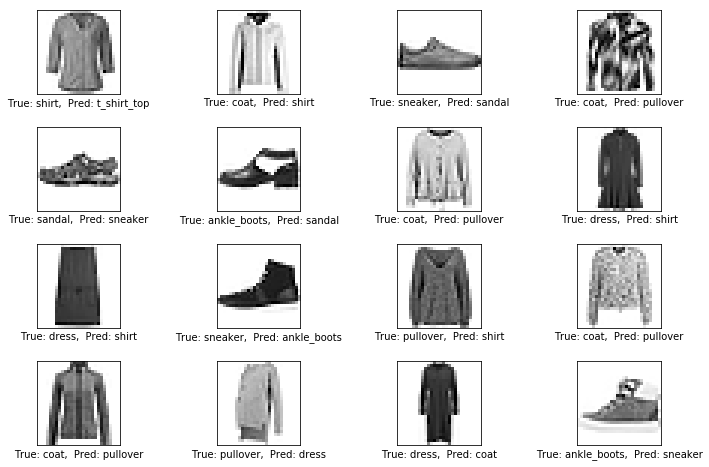

In [21]:
# Call the helper function
plot_example_errors()

As you can see from the results above, some results are close. At least they have similar shapes such as ankle_boots vs sneaker. Some are total nonsense. Hopefully the results will increase if we use convolutional neural networks in the next jupyter notebook.

### Confusion matrix
At last, let's quantify misclassification rate by using a confusion matrix from scikit-learn.

URL: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [22]:
# Defining a helper function to plot a confusion matrix
def plot_confusion_matrix():
    """
    
    Plot confusion matrix between true and predicted labels
    
    """
    # Get the confusion matrix using scikit-learn
    cm = confusion_matrix(y_true=data.test.cls,
                          y_pred=pred_label)

    # Print the confusion matrix as text
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(NUM_CLASSES)
    plt.xticks(tick_marks, LABELS)
    plt.yticks(tick_marks, LABELS)
    plt.xlabel('Predicted')
    plt.ylabel('True')

[[814   0  12  10   3   1 148   0  12   0]
 [  4 971   1  14   2   0   6   0   2   0]
 [ 31   1 867   6  46   0  49   0   0   0]
 [ 30   9  26 853  39   0  42   0   1   0]
 [  1   2 184  15 681   0 117   0   0   0]
 [  0   0   0   2   0 941   0  31   1  25]
 [139   2 117  19  44   0 663   0  16   0]
 [  0   0   0   0   0   6   0 925   2  67]
 [  2   1   5   6   3   1   6   4 972   0]
 [  0   0   0   0   0   1   1  16   0 982]]


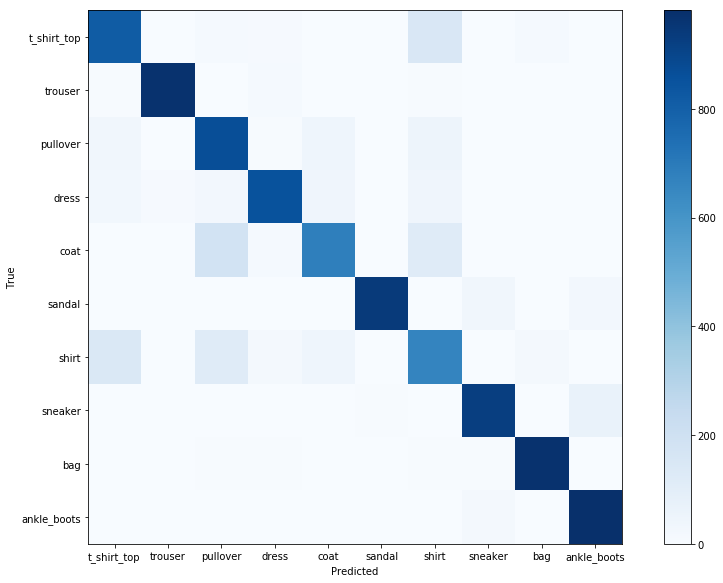

In [23]:
# Call the helper function
plot_confusion_matrix()

Clearly, you are seeing a distinct diagonal dark blue color here. This indicates that the simple CNN model is working well on this fashion MNIST problem compared to the simple linear classification we performed last time.